# Welcome to the PYNQ Audio Breakout
This notebook aims to provide an introduction to digital signal processing (DSP) in the context of audio. By the end of this notebook, you will:
- Have an understanding of analogue and digital signals.
- Have been introduced to the concepts of quantisation and sampling.
- Know how to record and playback audio using Jupyter and the PYNQ-Z2 board. 
- Visualise digital signals in both the time and frequency domains. 
- Learn some fundamentals of DSP such as adding signals and digital filtering.
- Learn how to use Google's Speech API. 

**NB:** *Please be concious of the volume levels; protect your hearing! Be especially careful when generating your own audio data for playback.*

## Table of Contents
1. [Setup (5 mins)](#1.-Setup)
2. [Install Dependencies (5 mins)](#2.-Install-Dependencies)
3. [Import Libraries (~mins)](#3.-Import-Libraries)
4. [Capturing Audio for use in Digital Systems (15 mins)](#4.-Capturing-Audio-for-use-in-Digital-Systems)
5. [Recording and Playing Audio on the PYNQ-Z2 (5 mins)](#5.-Recording-and-Playing-Audio-on-the-PYNQ-Z2)
6. [Visualising Audio Data (5 mins)](#6.-Visualising-Audio-Data)
7. [Basic Digital Signal Processing (10 mins)](#7.-Basic-Digital-Signal-Processing)
8. [Google's Speech API (5 mins)](#8.-Google's-Speech-API)

## 1. Setup 
To run through this notebook, all that is required is a **PYNQ-Z2 board with an internet connection** and a set of **headphones with a built in microphone and a 3.55 mm jack**. 

**Jupyter Lab** must be used to render some plots. This can be acheived by adding **/lab** to the regular path: `http://pynq:9090/lab`

<p align="center">
  <img src="./data/PYNQ-Z2-HP-MIC.png" width="750" height="350" />
<p/>

Insert the headphone jack into the `HP+MIC` port on the PYNQ-Z2 board. It is highlighted in the blue box in the top left of the picture above.

## 2. Install Dependencies

In [ ]:
!apt update
!apt install -y sox ffmpeg flac
!pip3 install gtts pysndfx speechRecognition pydub

## 3. Import Libraries

In [1]:
import speech_recognition as sr
from pynq.overlays.base import BaseOverlay
from pysndfx import AudioEffectsChain
from gtts import gTTS
from pydub import AudioSegment
from IPython.display import Audio
import numpy as np
import ipywidgets as ipw
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## 4. Capturing Audio for use in Digital Systems
This section will discuss some of the underlying principals for capturing signals for use in digital systems. 

It's **not** neccessary to completely understand all the material in this section in order to exploit the audio features of PYNQ. But it's good to know and gives us something to do while the relevant dependencies install. 

### 4.1 How is audio captured?
Real world signals, like sound, have to be translated into a format the can be processed by digital systems. The image below shows the main stages of this process.

<p align="center">
  <img src="./data/Capturing-Audio-Data.png" width="1000" height="350" />
<p/>

Sound, as it exists in the real world, is just a type of energy called *sound energy*. 

For it to be useful to us, it must be convereted into a type of energy electrical systems can understand. That's where the transducer comes in. A transducer converts one form of energy to another. In our case, the microphone acts as our transducer, converting *sound energy* to an *electrical energy* like voltage.

The voltage produced by the microphone is an *analogue* signal. To understand what this means, think about taking a point on the graph and measuring the time value (x-axis) and the voltage (y-axis). For example, is the voltage 1 V or 1.01 V or 1.0000001V. The same is true for the time value. Is it at 3 s or 3.00000000001 s. How exact can it be? 
In analogue systems, the precision is effectively infinite - meaning it gets smaller and smaller forever. 

This type of signal is no good for use in our digital system. In digital systems, values are represented as binary bits. This means the more values you want to represent, the more bits you need to use. Representing too many values is impractical. It will take up too much memory and can have other consequences like requiring a lot of power. 

An ADC takes this continuous analogue signal and converts it to a discrete digital signal. For voltage, you can think of it as rounding the voltage to a particular number of decimal points. An ADC rounds to a number of bits. The ADC used on the PYNQ-Z2 has 24-bit precision. This process is called *quantisation*. 

For time, the ADC takes a sample at a regular interval. This is referred to as *sampling*. For instance, audio is sometimes sampled at 48 kHz. That is, the audio is sampled 48000 times a second. 

**Quantisation** and **sampling** are two fundametal concepts in digital signal processing. 

#### Define Functions
The plots and sliders below are created using the [plotly](https://plotly.com/) library and [ipywidgets.](https://ipywidgets.readthedocs.io/en/latest/)

In [2]:
from scipy import signal

# This function assumes one signed bit and the remaining fractional
def float2fixed(data_array, bits):
    q = 2**bits
    steps = np.linspace(-1, 1-(2/q), q)
    
    fixed_point = []
    for i in data_array:
        fixed_point.append(min(steps, key=lambda x:abs(x-i)))
    return fixed_point

# Callback function to update graph when bits are changed
def update_quant(bits):
    update_samp(s_slider.value)

# Callback fundtion to update graph when sample rate is changed
def update_samp(freq):
    space = int(1024/(s_slider.value))
    indices = np.arange(0,1024,space)
    sampled = np.repeat(np.take(y, indices),space)
    q_fig.data[1].y = float2fixed(sampled, q_slider.value)
    q_fig_err.data[0].y = y - q_fig.data[1].y
    calc_mem()

# Calculate the memory usage
def calc_mem():
    bits = q_slider.value
    bytes = bits / 8
    sample = s_slider.value
    memory.value = str(bytes * sample)

### 4.2 Quantisation and Sampling

In [3]:
x = np.linspace(0, 9, 1024)
y = np.sin(x)
y_q = float2fixed(y, 8)

# Figure to display sinusoid
q_fig = go.FigureWidget()
q_fig.add_scatter(y=y, name='Analogue')
q_fig.add_scatter(y=y_q, name='Digital')
q_fig.layout.title = "Representing Digital Signals"
q_fig.layout.xaxis.title = "Samples [n]"
q_fig.layout.yaxis.title = "Amplitude"

# Figure to display error
q_fig_err = go.FigureWidget()
q_fig_err.add_scatter(y=y-y_q, name='Error', showlegend=True)
q_fig_err.layout.title = "Error (Analogue - Quantised)"
q_fig_err.layout.yaxis.range = [-1, 1]
q_fig_err.layout.xaxis.title = "Samples [n]"
q_fig_err.layout.yaxis.title = "Amplitude"

# Slider widget to select the number of bits
style = {'description_width': 'initial'}
q_slider = ipw.IntSlider(min=1, max=8, step=1, value=8, 
                       description='Precision (bits): ',
                       layout=ipw.Layout(width='95%'),
                       style=style,
                       continuous_update=False)

# Slider widget to change the sample rate
style = {'description_width': 'initial'}
s_slider = ipw.FloatLogSlider(min=0, max=10, step=1, value=1024, base=2,
                       description='Sample Rate (kHz): ',
                       layout=ipw.Layout(width='95%'),
                       style=style,
                       continuous_update=False)

# Textbox widget
memory = ipw.Text(
    value='1024',
    description='Memory (kB per s):',
    disabled=False
)

# Handler - links the slider to the callback function
q_slider.observe(update_quant, names='value')
s_slider.observe(update_samp, names='value')

# Diplay the figures and slider stacked vertically
display(ipw.VBox([q_fig, q_fig_err, q_slider, s_slider,memory], layout=ipw.Layout(height='750px')))

    'data': [{'name': 'Analogue',
              'type': 'scatter',
             …

## 5. Recording and Playing Audio on the PYNQ-Z2

### 5.1 Create new audio object

In [4]:
base = BaseOverlay("base.bit")
pAudio = base.audio

### 5.2 Bypass audio
Users can select either `LINE_IN`, or `HP+MIC` as the input port.
**

In the following example, we choose `HP+MIC`. To select this:
```python
pAudio.select_microphone()
```
or choose `LINE_IN`:
```python
pAudio.select_line_in()
```

**Try it first with your earbuds out**

In [5]:
pAudio.select_microphone()

In [6]:
pAudio.bypass(seconds=5)

### 5.3 Record
Record a 5-second sample and save it into a file.

In [7]:
pAudio.record(5)
pAudio.save("data/recording.wav")

### 5.4 Load and play
Load a file and play the loaded samples.

In [8]:
pAudio.load("data/recording.wav")
pAudio.play()

### 5.6 Adding effects
Create a new file with effects added. [Information for effects can be found here](https://github.com/carlthome/python-audio-effects/blob/master/pysndfx/dsp.py)

In [9]:
fx = AudioEffectsChain().delay().reverb()

In [10]:
fx("data/recording.wav","data/recording.ogg")

### 5.7 Play in notebook
Since the samples are in 24-bit PCM format, 
users can play the audio directly in notebook.

In [11]:
Audio("data/recording.ogg")

## 6. Visualising Audio Data

Users can display the audio data in notebook. In this section we will:

1. Extract the audio signal from the *.wav file.
2. Plot the audio signal's amplitude over time.
3. Plot the audio signal's frequency response. 
4. Plot the spectrogram of the audio signal.

### 6.1 Extract PCM data from *.wav
The next cell reads the saved audio file and processes it into a `numpy` array.
Note that if the audio sample width is not standard, additional processing
is required. In the following example, the `sample_width` is read from the
wave file itself (24-bit dual-channel PCM audio, where `sample_width` is 3 bytes).

In [12]:
%matplotlib inline
import wave
import matplotlib
from scipy.fftpack import fft, fftfreq

wav_path = "data/recording.wav"
with wave.open(wav_path, 'r') as wav_file:
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()
    
temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])

### 6.2 Amplitude over time

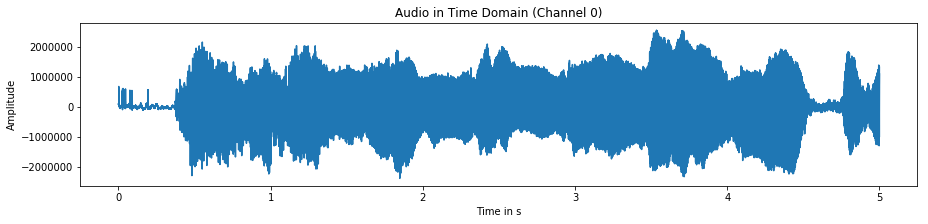

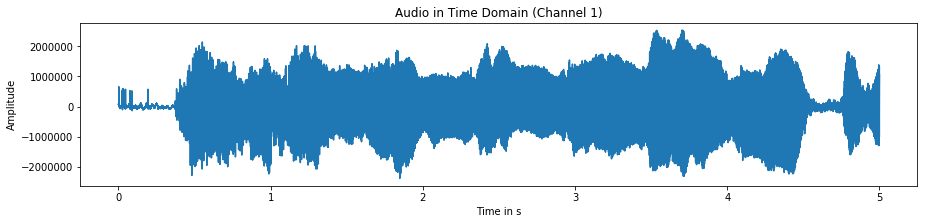

In [13]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, frames[:, channel_index])
    plt.show()

### 6.3 Frequency spectrum

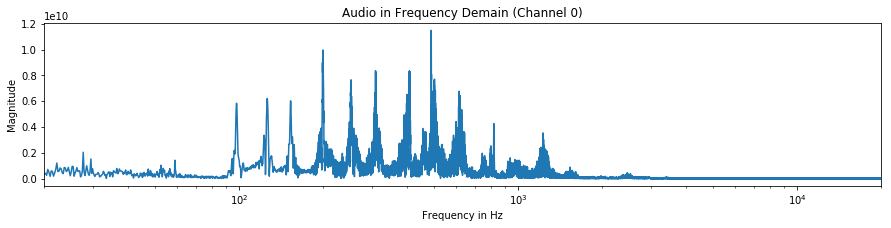

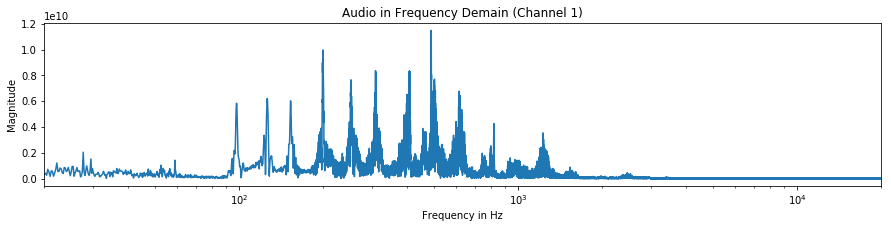

In [14]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))
    plt.xlabel('Frequency in Hz')
    plt.xscale('log')
    plt.ylabel('Magnitude')
    temp = fft(frames[:, channel_index])
    yf = temp[1:len(temp)//2]
    xf = np.linspace(0.0, sample_rate/2, len(yf))
    plt.xlim(20,20000)
    plt.plot(xf, abs(yf))
    plt.show()

### 6.4 Frequency spectrum over time
Use the `classic` plot style for better display.

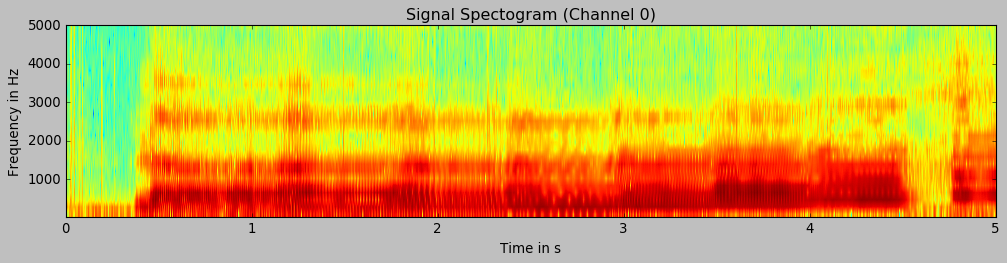

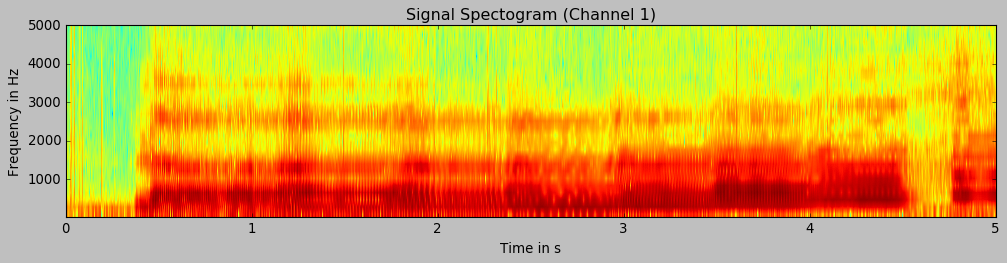

In [15]:
for channel_index in range(num_channels):
    np.seterr(divide='ignore', invalid='ignore')
    matplotlib.style.use("classic")
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Signal Spectogram (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')

    plt.ylabel('Frequency in Hz')
    plt.specgram(frames[:, channel_index], Fs=sample_rate)
    plt.ylim(20,5000)

## 7. Basic Digital Signal Processing
When a signal is in a digital format, we can manipulate it easily using Python and a little digital signal processing (DSP) knowledge.
In this section we will:
1. Create an interference signal using the formula for a sine wave: y(t) = Asin(2πft + φ)
2. Add the interference signal to our recorded audio.
3. Apply a digital filter to remove the interference.

### 7.1 Generate interference signal
#### Define Functions

In [16]:
# Callback function to update the desired frequency
def update_freq(fd):
    fs = sample_rate
    fd = fd['new']          # Desired frequency
    L = len(frames)         # Frame Size
    t = np.arange(L)/fs
    update_freq.interference = np.sin(2*np.pi*fd*t)
    
    scatter_time = fig_time.data[0]
    scatter_time.y = update_freq.interference[0:2048]
    scatter_freq = fig_freq.data[0]
    scatter_freq.y = fft_db(update_freq.interference[0:2048])

# Caclulate fft as power (dB)
def fft_db(data):
    data_fft = np.fft.fft(data)
    fft_shift = np.fft.fftshift(data_fft)
    fft_power = 20*np.log10(abs(fft_shift)**2)
    return fft_power

In [18]:
# Figure to display time domain data
fig_time = go.FigureWidget()
fig_time.add_scatter(y=[])
fig_time.layout.title = "Time Domain"
fig_time.layout.xaxis.range = [0, 2048]
fig_time.layout.xaxis.title = "Samples [n]"
fig_time.layout.yaxis.title = "Amplitude"

# Figure to display frequency domain data
fig_freq = go.FigureWidget()
fig_freq.add_scatter(y=[], x=np.arange(0, 1, 1 / 2048) * sample_rate - sample_rate / 2)
fig_freq.layout.title = "Frequency Domain"
fig_freq.layout.xaxis.title = "Frequency (Hz)"
fig_freq.layout.yaxis.title = "Power (dB)"

# Slider widget to select the frequency
style = {'description_width': 'initial'}
slider = ipw.IntSlider(min=0, max=20000, step=1, value=200, 
                       description='Desired Frequency (Hz): ',
                       layout=ipw.Layout(width='95%'),
                       style=style)

# Handler - links the slider to the callback function
slider.observe(update_freq, names='value')

# Diplay the figures and slider stacked vertically
display(ipw.VBox([fig_freq, fig_time, slider], layout=ipw.Layout(height='750px')))

    'data': [{'type': 'scatter',
              'uid': 'c39d912c-7d76-4f02-8a3f-d…

Create interference on both channels:

In [19]:
single_ch_inter = (update_freq.interference * 2**18).astype(int)
two_ch_inter = np.asarray([single_ch_inter, single_ch_inter])

Play in notebook:

In [20]:
Audio(two_ch_inter, rate=48000)

To play on the board, we can directly assign our audio data array to the `pAudio` buffer and then call `play()` to play the data in the buffer.

In [21]:
pAudio.buffer = np.ascontiguousarray(np.transpose(two_ch_inter))
pAudio.sample_len = len(pAudio.buffer)
pAudio.sample_rate = sample_rate
pAudio.configure(sample_rate=pAudio.sample_rate)

In [22]:
pAudio.play()

### 7.2 Add interference to audio
Adding interference is as simple as summing each element in the arrays (recorded audio + interference) together and can be accomplished using the '+' operator (provided the array shapes match).

In [23]:
audio_with_interference = frames + np.ascontiguousarray(np.transpose(two_ch_inter))

Compare the amplitude response here to the response from [earlier](#6.2-Amplitude-over-time). Can you easily determine what the interference is? 

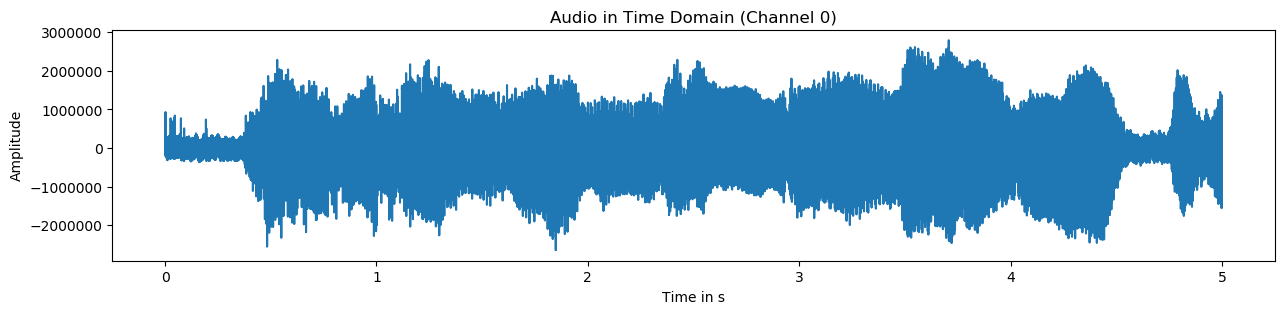

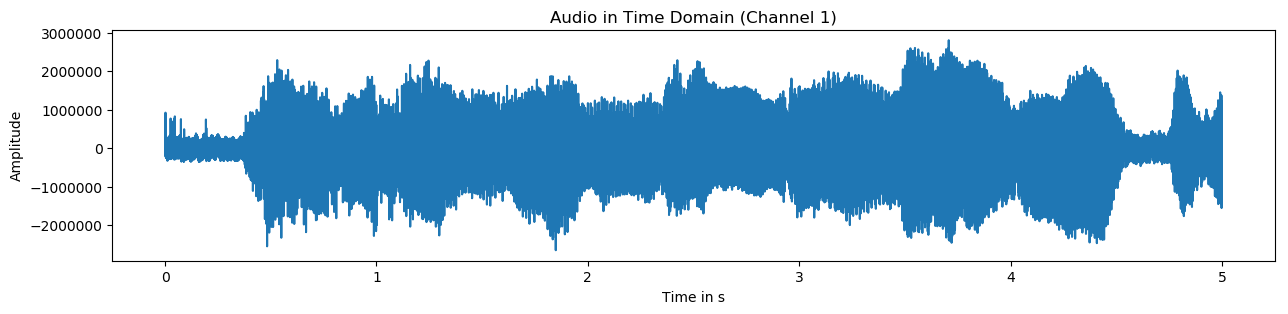

In [24]:
matplotlib.style.use("default")
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, audio_with_interference[:, channel_index])
    plt.show()

Now compare the frequency response to the response from [earlier](#6.3-Frequency-spectrum). Can you see a difference? 

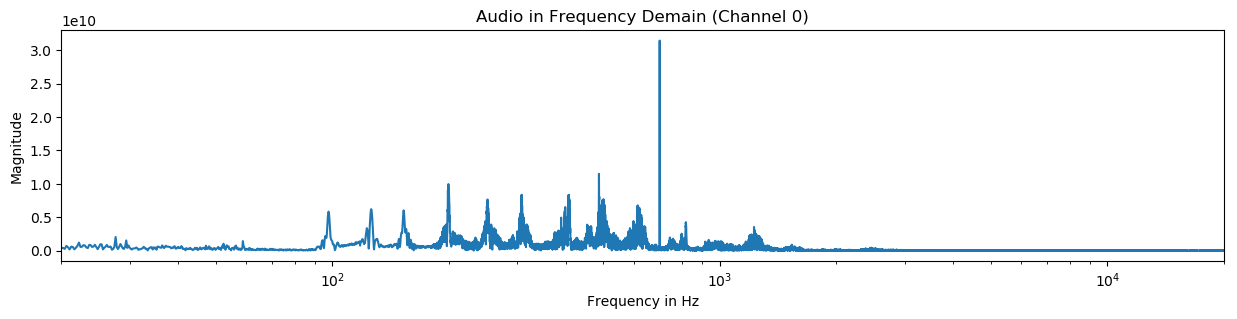

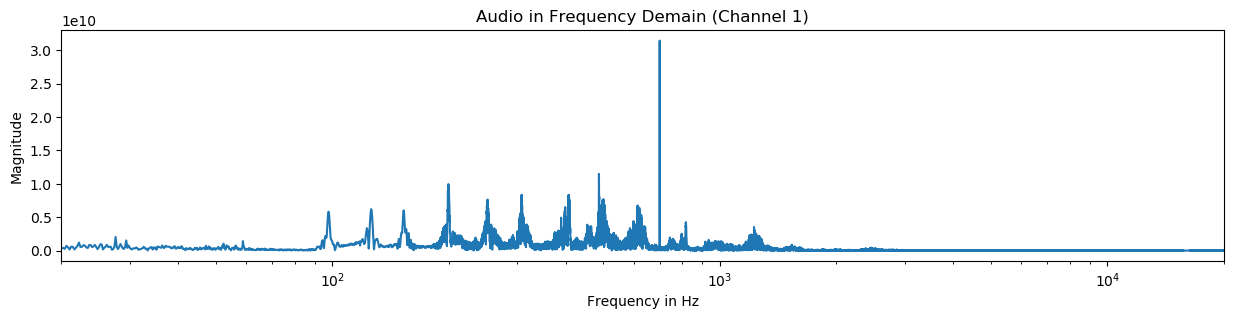

In [25]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))
    plt.xlabel('Frequency in Hz')
    plt.xscale('log')
    plt.ylabel('Magnitude')
    temp = fft(audio_with_interference[:, channel_index])
    yf = temp[1:len(temp)//2]
    xf = np.linspace(0.0, sample_rate/2, len(yf))
    plt.xlim(20,20000)
    plt.plot(xf, abs(yf))
    plt.show()

Listen to the recorded audio with the interference signal in the notebook:

In [26]:
Audio(np.ascontiguousarray(np.transpose(audio_with_interference)), rate=48000)

### 7.3 Digital filtering
If we have particular frequency components that we do not desire in our signal, we can remove these through a process called *digital filtering*. Below are some functions defining common digital filters. 

#### Define Functions

In [27]:
from scipy import signal

def generate_lowpass(fs, cutoff, trans_width, numtaps):
    taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def generate_highpass(fs, cutoff, trans_width, numtaps):
    taps = signal.remez(numtaps, [0, cutoff - trans_width, cutoff, 0.5*fs], [0, 1], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def generate_bandpass(fs, cutoff, trans_width, numtaps):
    edges = [0, cutoff[0] - trans_width, cutoff[0], cutoff[1], cutoff[1] + trans_width, 0.5*fs]
    taps = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def generate_bandstop(fs, cutoff, trans_width, numtaps):
    edges = [0, cutoff[0] - trans_width, cutoff[0], cutoff[1], cutoff[1] + trans_width, 0.5*fs]
    taps = signal.remez(numtaps, edges, [1, 0, 1], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

We can plot the response of our digital filter to better visualise its characteristics. Frequencies with a gain of zero will not be effected by the filter, whereas frequencies with a negative gain will be suppressed. 

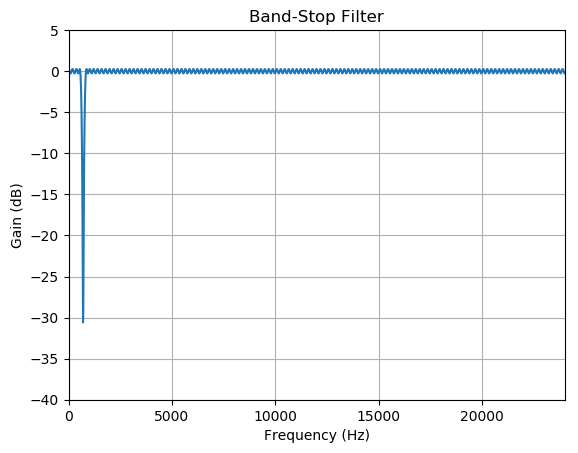

In [28]:
fs = sample_rate
cutoff = [695, 705]
transition = 125
number_taps = 501
w, h, coeffs = generate_bandstop(fs, cutoff, transition, number_taps)
plot_response(fs, w, h, title = "Band-Stop Filter")

Plotting the frequency response of the filtered signal, we can see the interference has been suppressed.

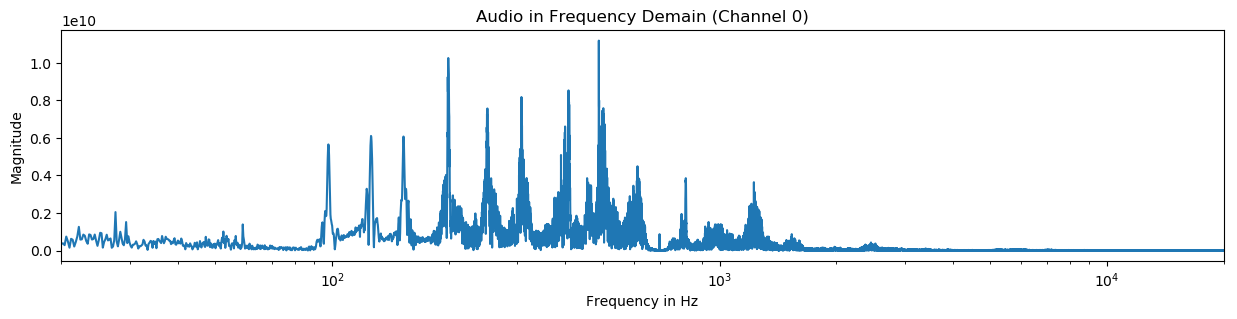

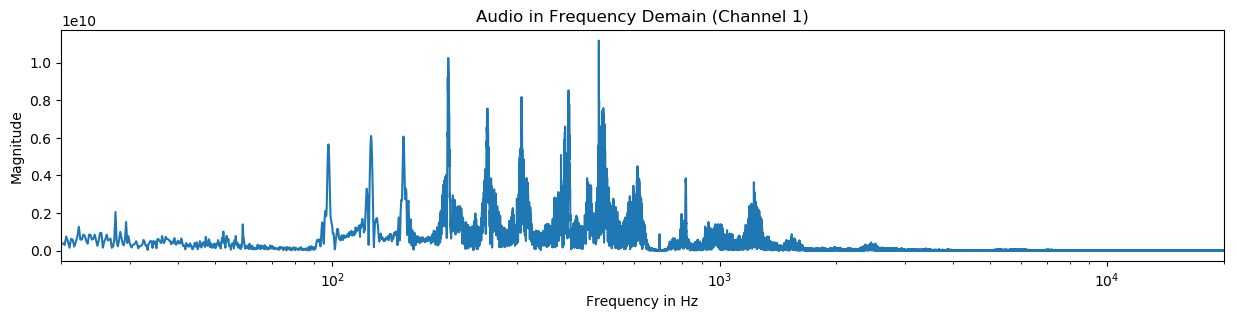

In [29]:
ch_0 = signal.lfilter(coeffs, [1], audio_with_interference[:, 0] / 2**18)
ch_1 = signal.lfilter(coeffs, [1], audio_with_interference[:, 1] / 2**18)
filtered_audio = (np.ascontiguousarray(np.transpose(np.asarray([ch_0, ch_1])))* 2**18).astype(int)

for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Frequency Demain (Channel {})'.format(channel_index))
    plt.xlabel('Frequency in Hz')
    plt.xscale('log')
    plt.ylabel('Magnitude')
    temp = fft(filtered_audio[:, channel_index])
    yf = temp[1:len(temp)//2]
    xf = np.linspace(0.0, sample_rate/2, len(yf))
    plt.xlim(20,20000)
    plt.plot(xf, abs(yf))
    plt.show()

We can listen to it to confirm with our ears also!

In [30]:
Audio(np.ascontiguousarray(np.transpose(filtered_audio)),rate=48000)

## 8. Google's Speech API
### 8.1 Using Text to Speech
You can use this wrapper for Google's text-to-speech service to produce natural sounding speech.

In [31]:
words = "Hello World!"
tts = gTTS(words)
tts.save("data/hello.mp3")
mp3 = AudioSegment.from_mp3("data/hello.mp3")
mp3.export("data/hello.wav", format="wav")

<_io.BufferedRandom name='data/hello.wav'>

In [32]:
Audio("data/hello.wav")

### 8.2 Using Speech to Text
You can use this wrapper for Google's speech recognition service to extract words from an audio file.

In [33]:
pAudio.select_microphone()
pAudio.record(5)
pAudio.save("data/record_speech.wav")

In [34]:
r = sr.Recognizer()

with sr.AudioFile("data/record_speech.wav") as source:
    audio = r.record(source)

In [35]:
r.recognize_google(audio)

'thanks for the sending the audio breakout session hope you enjoyed it'